In [1]:
# modules we'll use

import numpy as np
import pandas as pd
import gensim
import tensorflow as tf
import sys

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

#mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#sys.path.insert(0,'/content/drive/MyDrive/Praca_Inżynierska/kickstarter/code')

from preprocessing.label_binarizer import DataFrameLabelBinarizer
from preprocessing.mean_embedding_vector import MeanEmbeddingVectorizer
from plotting.loss_plotter import LossPlotter
from plotting.real_pred_plotter import RealPredPlotter

C:\Users\micha\Anaconda3\envs\kickstarter\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# read in all our data
# Google Drive's path: /content/drive/MyDrive/Praca_Inżynierska/kickstarter/data/spotify.csv
spotify_orig  = pd.read_csv("../data/spotify.csv")
# set seed for reproducibility
np.random.seed(0)

In [3]:
# look at a few rows of the Spotify dataset file
spotify_orig.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
107349,0.817,2013,0.015800,['Parmalee'],0.551,214933,0.863,0,3Bdqlr7jQLNhITAgcBGQBG,0.0000,11,0.0843,-3.506,1,Close Your Eyes,50,2013-12-10,0.0322,143.952
16271,0.548,2003,0.006610,['JAY-Z'],0.494,234627,0.887,1,7sLpSWxQazJzDVG6YGzlVs,0.0000,6,0.1030,-4.297,0,99 Problems,61,2003-11-14,0.3980,89.554
90972,0.732,2014,0.047700,['Sam Hunt'],0.590,235507,0.940,0,3BuPop8SzLG2Q88TJcFAjp,0.0000,9,0.3790,-4.124,1,Raised On It,54,2014-10-27,0.0409,94.020
84553,0.475,1981,0.000473,['Iron Maiden'],0.340,288947,0.974,0,7EvjTEzuv7TWaIaWY63sWV,0.0928,0,0.3730,-5.114,1,Drifter - 2015 Remaster,29,1981-02-02,0.1060,101.276
75895,0.550,1930,0.994000,"['Markos Vamvakaris', 'Apostolos Xatzixristos']",0.410,197653,0.169,0,38PozVGXXoeO8dTEVzy74Y,0.9010,2,0.1130,-18.862,1,Soultana maurofora,0,1930-01-01,0.0391,93.890


In [4]:
# get info about DataFrame columns
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [5]:
# convert 'key' to one-hot-encoded
lb_category = DataFrameLabelBinarizer(data_frame=spotify_orig, column_to_encode='key')
spotify_converted = lb_category.encode()

In [6]:
# convert release_date to milliseconds
spotify_converted['release_date'] = pd.to_datetime(spotify_converted['release_date'], format = "%Y-%m-%d").astype(np.int64) / 10**9

In [7]:
# convert 'name' to embedding (vector)
# Google Drive's path: /content/drive/MyDrive/Praca_Inżynierska/kickstarter/data/spotify_track_names_embedding.bin
names_w2v = gensim.models.KeyedVectors.load_word2vec_format(fname="./data/spotify_track_names_embedding.bin", binary=True)
embedding_vectorizer = MeanEmbeddingVectorizer(names_w2v)
spotify_converted = embedding_vectorizer.transform(data_frame=spotify_converted, column_to_encode='name')

In [8]:
# drop redundant columns
spotify_reduced = spotify_converted.drop(['artists', 'year', 'id'], axis=1)

In [9]:
# get info about DataFrame columns
spotify_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Columns: 326 entries, valence to 299
dtypes: float64(310), int32(12), int64(4)
memory usage: 416.6 MB


In [10]:
# look at a few rows of the Spotify dataset
spotify_converted.sample(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,290,291,292,293,294,295,296,297,298,299
165043,0.933,1992,0.613,['Luisito Ayala Y Su Puerto Rican Power'],0.748,308733,0.4780,0,7fmQmw1o2qCnb5sCS23GRL,0.000000,...,0.020760,0.060698,0.114919,-0.034475,0.067920,0.026761,-0.040640,0.003962,-0.047898,-0.042998
166209,0.674,1998,0.230,['Dire Straits'],0.714,243467,0.5230,0,134JuWUat5SCHkIYEtRvO7,0.069900,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
115563,0.498,1973,0.135,['Grateful Dead'],0.393,198120,0.4190,0,3nWV4Uk4A3TlVHYxiHSnaF,0.048100,...,0.015832,0.057823,-0.027111,-0.003492,0.049744,0.140848,-0.022142,-0.023940,0.010803,0.099177
115716,0.917,1974,0.573,['Jim Croce'],0.714,211080,0.5300,0,5XFePcMXoruH1Jna66uzyx,0.000047,...,0.023231,0.052384,-0.012889,0.007307,0.066080,0.178426,-0.004036,-0.024705,-0.015178,0.104874
41267,0.257,1940,0.995,['Frank Campbell Milne'],0.525,203920,0.0535,0,0l2JmVd1UDopW2S1bb7PRm,0.939000,...,0.034153,0.052795,-0.013588,-0.006537,0.057280,0.137462,-0.000086,-0.025861,-0.040044,0.111853


In [11]:
# get index of 'popularity' column
popularity_index = spotify_reduced.columns.get_loc("popularity")

In [12]:
# convert to numpy_array
spotify_numpy = spotify_reduced.to_numpy()

In [13]:
# get X and y from numpy array
X = np.delete(arr=spotify_numpy, obj=popularity_index, axis=1)
y = spotify_numpy[:, popularity_index]

In [14]:
# get train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [15]:
# create model

model = keras.models.Sequential()

model.add(layers.Input(shape=(X_train.shape[1],), name='inputs'))

model.add(layers.Dense(units=100, kernel_initializer=keras.initializers.he_normal(), bias_initializer=keras.initializers.he_normal(),
                       activation=keras.activations.elu, name='hidden1'))
model.add(layers.BatchNormalization(momentum=0.99))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=50, kernel_initializer=keras.initializers.he_normal(), bias_initializer=keras.initializers.he_normal(),
                       activation=keras.activations.elu, name='hidden2'))
model.add(layers.BatchNormalization(momentum=0.99))
model.add(layers.Dropout(rate=0.5))

model.add(layers.Dense(units=1, activation=keras.activations.linear, name="outputs"))
model.add(layers.BatchNormalization(momentum=0.99))

#print model details
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               32600     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 5

In [16]:
# train model
optimizer = tf.compat.v1.train.MomentumOptimizer(learning_rate=0.05, momentum=0.99, use_nesterov=True)
model.compile(optimizer=optimizer, loss=keras.losses.mse, metrics=[keras.metrics.mse, keras.metrics.mae, keras.metrics.RootMeanSquaredError(name='rmse')])
history=model.fit(X_train, y_train, epochs=10, batch_size=170, verbose=1, validation_split=0.2)

Epoch 1/10
563/563 [==============================] - 2s 3ms/step - loss: 147.8966 - mean_squared_error: 147.8966 - mean_absolute_error: 9.0955 - rmse: 12.1613 - val_loss: 114.3581 - val_mean_squared_error: 114.3581 - val_mean_absolute_error: 7.9093 - val_rmse: 10.6938

In [17]:
# print model loss
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'rmse', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'val_rmse'])


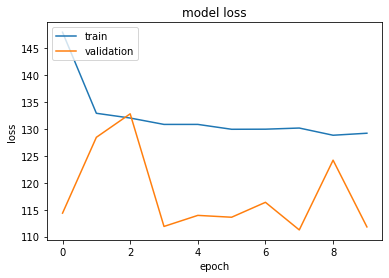

In [18]:
loss_plotter = LossPlotter(history)
loss_plotter.plot()

In [19]:
# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_test, y_test, batch_size=170)
print(results)

302/302 [==============================] - 0s 1ms/step - loss: 108.1478 - mean_squared_error: 108.1478 - mean_absolute_error: 7.6900 - rmse: 10.3994

In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 10 samples")
predictions = model.predict(X_test[:10])
print("predictionas")
print(predictions)
real = np.reshape(y_test[:10], (-1, 1))
real_pred = np.append(real, predictions, axis=1)
print("real/predictions")
print(real_pred)

Generate predictions for 10 samples
predictionas
[[36.216064]
 [35.887745]
 [43.483368]
 [15.719858]
 [-0.737257]
 [57.646828]
 [34.535957]
 [ 8.377655]
 [28.399162]
 [39.281258]]
real/predictions
[[34.         36.21606445]
 [26.         35.8877449 ]
 [38.         43.48336792]
 [13.         15.71985817]
 [ 0.         -0.737257  ]
 [62.         57.6468277 ]
 [23.         34.53595734]
 [ 0.          8.37765503]
 [25.         28.39916229]
 [25.         39.28125763]]


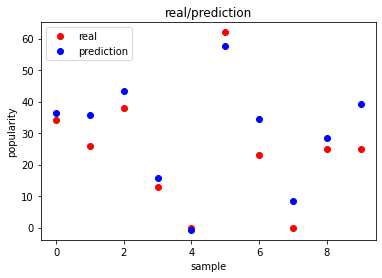

In [21]:
# plot real/pred chart
real_pred_plot = RealPredPlotter(real=real, pred=predictions)
real_pred_plot.plot()